## About this notebook

This notebook presents a complete pipeline for classifying argument relations (Support vs Attack) from Kialo data. It generates Sentence-BERT embeddings, trains an MLP (with comparison to classical models), handles class imbalance and uses F1-based early stopping. Additional cells show the final evaluation (F1, confusion matrix) and how to make predictions from two sentences.

### Import the dataset

 You can check the notebook `2_txt_to_dataframe.ipynb` to see how the raw data from Kialo was processed.

In [ ]:
import pandas as pd

df = pd.read_csv('../../data/kialo/kialo-pairs-10k.csv')
# df = pd.read_csv('../../data/kialo/kialo-pairs-50k.csv')
# df = pd.read_csv('../../data/kialo/kialo-pairs-100k.csv')
df

,relation,parent_clean,child_clean
0,Attack,the kama sutra gives advice on how to commit a...,"according to the supreme court of india, prohi..."
1,Support,jesus fulfilled all prophecies concerning the ...,people would cast lots for the messiah's cloth...
2,Attack,the christian bible puts emphasis on the divin...,if the ability to make a wrong choice does not...
3,Support,having more sexual partners may provide a vari...,having more sexual partners could possibly inc...
4,Attack,marriage was once the pillar of society. the s...,marriage represents only one form of intimate ...
...,...,...,...
9995,Attack,families often use tv as a means to come toget...,a group of people watching tv merely brings th...
9996,Support,many heterosexual and lgbtq people are friends...,"the peel, a gay club which has the legal right..."
9997,Attack,moral relativism argues that morality is fluid...,"many religions exist, with many different gods..."
9998,Attack,that mandatory schooling helps parents save mo...,universal free childcare would be an enormous ...


### Generating Semantic Embeddings with Sentence-BERT

This block uses **Sentence-BERT**, a specialized model that converts sentences into numerical vectors (embeddings) capturing their meaning. 
Unlike word-by-word embeddings, Sentence-BERT understands the context of entire sentences, which is perfect for analyzing relationships between arguments.

We generate embeddings for both the **parent** and **child** arguments, then combine them with their **difference vector** to emphasize how they relate (whether they Support or Attack each other).

In [63]:
from sentence_transformers import SentenceTransformer
import numpy as np

class ArgumentEmbeddingGenerator:
    """
    Generate rich embeddings for argument pairs using Sentence-BERT
    - 'all-mpnet-base-v2': high-quality sentence-transformer for English
    - Cosine similarity: captures overall agreement/disagreement
    - Element-wise product: captures feature interactions
    - Element-wise difference: captures contrast between arguments
    - Manhattan & Euclidean distances: scalar distances for added contrast
    """
    def __init__(self, model_name='all-mpnet-base-v2'):
        print(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)
        # 'all-mpnet-base-v2' = 768 dims; 'all-MiniLM-L6-v2' = 384 dims for faster speed

    def generate_embeddings(self, df):
        """
        Generate rich feature representations of argument pairs
        Features:
        - parent_emb: embedding of parent argument
        - child_emb: embedding of child argument
        - diff_emb: element-wise absolute difference
        - product_emb: element-wise product
        - cos_sim: cosine similarity (scalar)
        - manhattan_dist: sum of absolute differences (scalar)
        - euclidean_dist: L2 distance (scalar)
        """
        print("Generating embeddings...")

        # Encode both arguments
        parent_emb = self.model.encode(
            df['parent_clean'].tolist(),
            show_progress_bar=True,
            batch_size=32
        )
        child_emb = self.model.encode(
            df['child_clean'].tolist(),
            show_progress_bar=True,
            batch_size=32
        )

        # Absolute difference (element-wise)
        diff_emb = np.abs(parent_emb - child_emb)

        # Element-wise product
        product_emb = parent_emb * child_emb

        # Cosine similarity (scalar)
        parent_norm = np.linalg.norm(parent_emb, axis=1, keepdims=True) + 1e-8
        child_norm = np.linalg.norm(child_emb, axis=1, keepdims=True) + 1e-8
        cos_sim = np.sum(parent_emb * child_emb, axis=1, keepdims=True) / (parent_norm * child_norm)

        # Manhattan distance (scalar)
        manhattan_dist = np.sum(diff_emb, axis=1, keepdims=True)

        # Euclidean distance (scalar)
        euclidean_dist = np.linalg.norm(diff_emb, axis=1, keepdims=True)

        # Concatenate all features
        combined = np.concatenate([
            parent_emb,      # 768 dims
            child_emb,       # 768 dims
            diff_emb,        # 768 dims
            product_emb,     # 768 dims
            cos_sim,         # 1 dim
            manhattan_dist,  # 1 dim
            euclidean_dist   # 1 dim
        ], axis=1)

        print(f"Final embedding dimension: {combined.shape[1]}")
        print(f"  - Parent embedding: {parent_emb.shape[1]}")
        print(f"  - Child embedding: {child_emb.shape[1]}")
        print(f"  - Difference: {diff_emb.shape[1]}")
        print(f"  - Product: {product_emb.shape[1]}")
        print(f"  - Cosine similarity: 1")
        print(f"  - Manhattan distance: 1")
        print(f"  - Euclidean distance: 1")

        return combined

# Usage
embedding_generator = ArgumentEmbeddingGenerator()
embeddings = embedding_generator.generate_embeddings(df)

Loading model: all-mpnet-base-v2


/home/nysek/miniconda3/envs/ddc_project/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating embeddings...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Final embedding dimension: 3075
  - Parent embedding: 768
  - Child embedding: 768
  - Difference: 768
  - Product: 768
  - Cosine similarity: 1
  - Manhattan distance: 1
  - Euclidean distance: 1


### Building a Neural Network for Argument Classification
This defines a **3-layer neural network** (`ArgumentClassifier`) to classify whether a child argument supports or attacks its parent. The architecture includes:

- **Dropout layers** to prevent overfitting by randomly deactivating neurons during training.
- **Batch normalization** to stabilize and speed up learning.
- **Progressive dimension reduction** to distill the most important features.

The goal is a model that generalizes well, not just memorizes the training data.

In [64]:
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class MLP(nn.Module):
    """
    Simple feedforward neural network for classifying argument pairs.
    Input: 3075-dimensional embedding vector
    Architecture:
    - Layer 1: 3075 -> 256 (ReLU, BatchNorm, Dropout)
    - Layer 2: 256 -> 64 (ReLU, BatchNorm, Dropout)
    - Output: 64 -> 1 (Logit for binary classification)
    """
    def __init__(self, input_dim=3075, dropout_rate=0.5):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate * 0.7)
        
        self.fc_out = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.fc_out(x)
        return x

input_dim = embeddings.shape[1]

models = {
    "mlp": MLP(input_dim=input_dim),
    "logreg": LogisticRegression(max_iter=2000),
    "rf": RandomForestClassifier(n_estimators=200, max_depth=20)
}

# Example: pick model by name
model = models["mlp"]
print(model)

MLP(
  (fc1): Linear(in_features=3075, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.35, inplace=False)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


### Training the Model with Smart Optimizations

This block sets up the training process with:

- **Adam optimizer**, which dynamically adjusts learning rates for efficient training.
- **Class-weighted loss** to handle imbalanced data (e.g., more "attack" than "support" examples).
- **Early stopping** to halt training if the model stops improving, saving time and preventing overfitting.
- **Learning rate scheduling** to fine-tune the model when progress stalls.

The result is a model that learns efficiently and generalizes effectively.

In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score

class ArgumentTrainer:
    """
    Trainer for binary classification with MLP.
    - Optimizes BCEWithLogitsLoss (with pos_weight for class balance).
    - Tracks F1-score during validation.
    - Early stopping and model checkpointing use validation F1.
    """

    def __init__(self, model, device, labels):
        self.model = model
        self.device = device
        self.model.to(device)
        
        # Optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
        
        # Balanced loss
        attack_count = (labels == 0).sum()
        support_count = (labels == 1).sum()
        pos_weight = torch.tensor([attack_count / support_count], device=device)
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # LR scheduler (based on validation loss, still useful for optimization)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5
        )

    def soft_f1_loss(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true = y_true.float()
        tp = (y_pred * y_true).sum()
        fp = (y_pred * (1 - y_true)).sum()
        fn = ((1 - y_pred) * y_true).sum()
        soft_f1 = 2 * tp / (2*tp + fp + fn + 1e-8)
        return 1 - soft_f1

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_targets = [], []

        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device).float().unsqueeze(1)
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = 0.5 * self.criterion(output, target) + 0.5 * self.soft_f1_loss(output, target)

            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            probs = torch.sigmoid(output.squeeze()).detach().cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_targets.extend(target.cpu().numpy())
            
            total += target.size(0)
            correct += (preds == target.cpu().numpy()).sum()

        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        f1 = f1_score(all_targets, all_preds)
        return avg_loss, acc, f1

    def validate(self, val_loader):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device).float().unsqueeze(1)
                output = self.model(data)
                loss = 0.5 * self.criterion(output, target) + 0.5 * self.soft_f1_loss(output, target)
                total_loss += loss.item()

                probs = torch.sigmoid(output.squeeze()).cpu().numpy()
                preds = (probs > 0.5).astype(int)
                all_preds.extend(preds)
                all_targets.extend(target.cpu().numpy())

                total += target.size(0)
                correct += (preds == target.cpu().numpy()).sum()

        avg_loss = total_loss / len(val_loader)
        acc = correct / total
        f1 = f1_score(all_targets, all_preds)
        return avg_loss, acc, f1

    def train(self, train_loader, val_loader, epochs=25, patience=5):
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        train_f1s, val_f1s = [], []

        best_val_f1 = 0.0
        patience_counter = 0

        print("Starting training...")

        for epoch in range(epochs):
            train_loss, train_acc, train_f1 = self.train_epoch(train_loader)
            val_loss, val_acc, val_f1 = self.validate(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)

            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
            print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # LR scheduler based on validation loss
            self.scheduler.step(val_loss)

            # Early stopping based on F1
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                patience_counter = 0
                torch.save(self.model.state_dict(), '../../models/best_model.pth')
                print(f"  ✅ New best model saved (Val F1 = {val_f1:.4f})")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"⏹ Early stopping after {epoch+1} epochs (no F1 improvement)")
                break

        # Load best model
        self.model.load_state_dict(torch.load('../../models/best_model.pth'))

        return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s


### Preparing Data and Evaluating Performance

Here, we:

- **Split the data** into training, validation, and test sets, ensuring balanced class representation.
- **Convert data to PyTorch tensors** for compatibility with the neural network.
- T**rain the model** and track metrics like loss and accuracy per epoch.
- **Evaluate performance** on the test set using:

    - **F1-score** to balance precision and recall.
    - **Confusion matrix** to visualize where the model succeeds or struggles.
    - **Training curves** to monitor progress and detect overfitting.

This ensures the model is both accurate and reliable.

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['relation'])

print(f"Mapping of labels: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
    
X_temp, X_test, y_temp, y_test = train_test_split(
    embeddings, labels, test_size=0.15, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 ≈ 15/85
)

print(f"Taille train: {len(X_train)}")
print(f"Taille validation: {len(X_val)}")
print(f"Taille test: {len(X_test)}")

# Converting tot PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Model architecture:")
print(model)

if isinstance(model, nn.Module):
    # PyTorch model (MLP)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Number of trainable parameters: {n_params}")
else:
    # Scikit-learn model (LogReg or RF)
    if hasattr(model, "coef_"):  # Logistic Regression
        n_params = model.coef_.size + model.intercept_.size
        print(f"Number of parameters: {n_params} (learned weights + bias)")
    elif hasattr(model, "estimators_"):  # Random Forest
        print(f"Number of trees: {len(model.estimators_)} (each with many parameters)")
    else:
        print("Parameter count not available for this model type.")

Device used: cuda
Mapping of labels: {'Attack': 0, 'Support': 1}
Taille train: 7004
Taille validation: 1496
Taille test: 1500
Model architecture:
MLP(
  (fc1): Linear(in_features=3075, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.35, inplace=False)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)
Number of trainable parameters: 804609


Starting training...
Epoch 1/25:
  Train Loss: 0.6097, Acc: 15.9751, F1: 0.3901
  Val   Loss: 0.5688, Acc: 16.1277, F1: 0.5585
  ✅ New best model saved (Val F1 = 0.5585)
Epoch 2/25:
  Train Loss: 0.5442, Acc: 16.0129, F1: 0.6257
  Val   Loss: 0.5351, Acc: 16.1889, F1: 0.6263
  ✅ New best model saved (Val F1 = 0.6263)
Epoch 3/25:
  Train Loss: 0.4993, Acc: 16.0370, F1: 0.6961
  Val   Loss: 0.5091, Acc: 16.2310, F1: 0.7043
  ✅ New best model saved (Val F1 = 0.7043)
Epoch 4/25:
  Train Loss: 0.4647, Acc: 16.0241, F1: 0.7337
  Val   Loss: 0.4933, Acc: 16.1766, F1: 0.7140
  ✅ New best model saved (Val F1 = 0.7140)
Epoch 5/25:
  Train Loss: 0.4363, Acc: 16.0269, F1: 0.7592
  Val   Loss: 0.4917, Acc: 16.1576, F1: 0.7100
Epoch 6/25:
  Train Loss: 0.4113, Acc: 16.0611, F1: 0.7739
  Val   Loss: 0.4946, Acc: 16.1780, F1: 0.6727
Epoch 7/25:
  Train Loss: 0.3894, Acc: 16.0393, F1: 0.7902
  Val   Loss: 0.5139, Acc: 16.1454, F1: 0.6515
Epoch 8/25:
  Train Loss: 0.3635, Acc: 16.0433, F1: 0.8042
  Val 

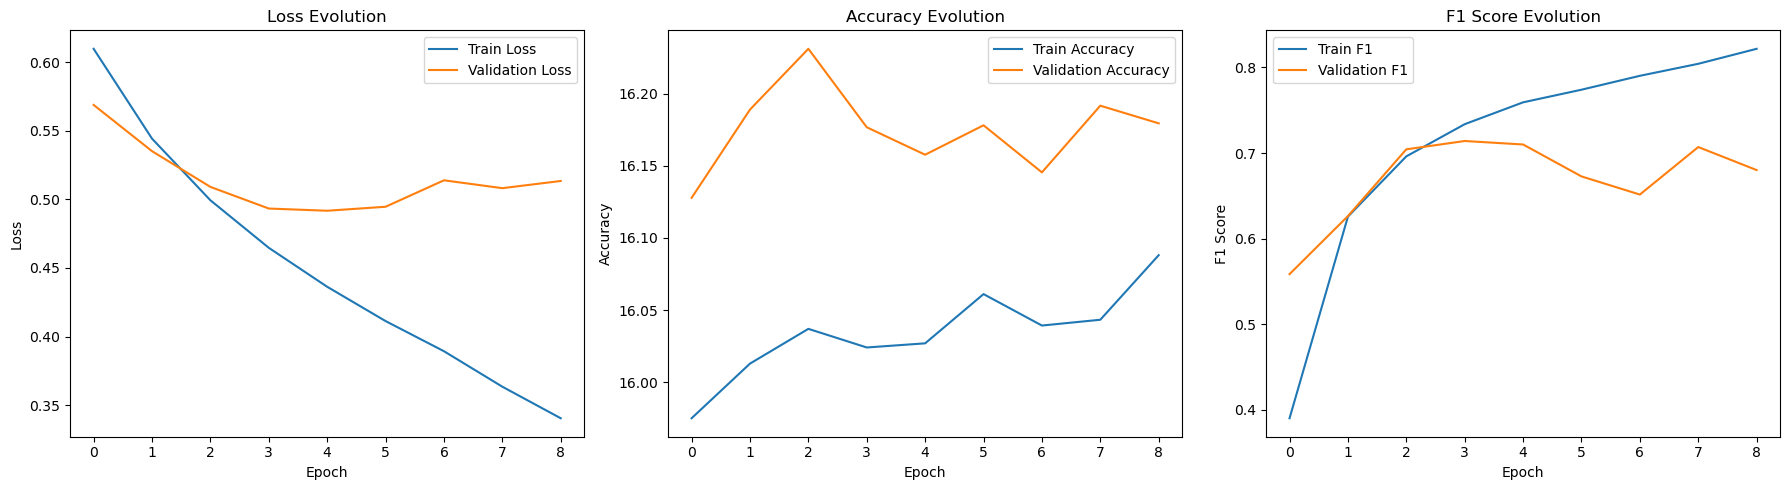

In [67]:
from sklearn.metrics import precision_recall_curve

def find_optimal_threshold(model, val_loader, device):
    """
    Find the threshold that maximizes F1-score on validation set
    """
    model.eval()
    val_probs = []
    val_true = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            output = model(data)
            # Convert logits to probabilities
            probs = torch.sigmoid(output).cpu().numpy().flatten()
            val_probs.extend(probs)
            val_true.extend(target.numpy())
    
    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(val_true, val_probs)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Find the threshold with maximum F1
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"Optimal threshold: {best_threshold:.3f}")
    print(f"F1 at optimal threshold: {best_f1:.4f}")
    print(f"F1 at 0.5 threshold: {f1_scores[np.argmin(np.abs(thresholds - 0.5))]:.4f}")
    
    return best_threshold

# Training / Evaluation depending on model type
if isinstance(model, nn.Module): # PyTorch (MLP)
    trainer = ArgumentTrainer(model, device, labels)
    train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = trainer.train(
        train_loader, val_loader, epochs=25, patience=5
    )

    # Find threshold
    best_threshold = find_optimal_threshold(model, val_loader, device)

    # Test evaluation
    model.eval()
    test_predictions, test_targets = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            probs = torch.sigmoid(model(data)).cpu().numpy().flatten()
            predicted = (probs > best_threshold).astype(int)
            test_predictions.extend(predicted)
            test_targets.extend(target.numpy())

else: # Scikit-learn (LogReg, RF)
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    test_targets = y_test
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  # no curves for sklearn

print("\n=== FINAL EVALUATION ===")

test_f1 = f1_score(test_targets, test_predictions)
print(f"F1-Score on the test set: {test_f1:.4f}")

print("\nClassification report:")
print(classification_report(test_targets, test_predictions, target_names=label_encoder.classes_))

print("\nConfusion matrix:")
cm = confusion_matrix(test_targets, test_predictions)
print(cm)

# Visualization
if train_losses:
    plt.figure(figsize=(18, 5))

    # --- Loss ---
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Evolution")
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Evolution")
    plt.legend()

    # --- F1 Score ---
    plt.subplot(1, 3, 3)
    plt.plot(train_f1s, label="Train F1")
    plt.plot(val_f1s, label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Evolution")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Summarizing Model Performance

This block calculates and displays key metrics:

- **Accuracy**, **precision**, **recall**, and **F1-score** for overall performance.
- **Class-specific stats** to identify strengths and weaknesses (e.g., does the model handle "support" better than "attack"?).

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(test_targets, test_predictions)
precision = precision_score(test_targets, test_predictions)
recall = recall_score(test_targets, test_predictions)
f1 = f1_score(test_targets, test_predictions)

print("\n=== FINAL STATISTICS ===")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

report = classification_report(test_targets, test_predictions, 
                               target_names=label_encoder.classes_,
                               output_dict=True)

print("\n=== STATISTICS BY CLASSES ===")
for cls in label_encoder.classes_:
    stats = report[cls]
    print(f"{cls}: Precision={stats['precision']:.3f}, Recall={stats['recall']:.3f}, F1={stats['f1-score']:.3f}, Support={stats['support']}")


=== FINAL STATISTICS ===
Accuracy  : 0.6653
Precision : 0.6305
Recall    : 0.7987
F1-score  : 0.7047

=== STATISTICS BY CLASSES ===
Attack: Precision=0.725, Recall=0.532, F1=0.614, Support=750.0
Support: Precision=0.631, Recall=0.799, F1=0.705, Support=750.0


### Predicting Argument Relationships in Practice

The `predict_relation` function takes two sentences and predicts whether the counter-claim **supports** or **attacks** the original claim. It includes examples like:

- "Climate change is caused by humans" vs. "Fossil fuels release greenhouse gases" → **Support**.
- "Social media is beneficial" vs. "It causes addiction" → **Attack**.

The output includes:

The predicted relationship (`Support`/`Attack`), with the confidence score.

This demonstrates how the model can be applied to real-world argument analysis.

In [69]:
from termcolor import colored

# --- Embedding generator ---
class ArgumentEmbeddingGenerator:
    def __init__(self, model_name='all-mpnet-base-v2'):
        print(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)

    def generate_embeddings(self, df):
        parent_emb = self.model.encode(df['parent_clean'].tolist(), show_progress_bar=True, batch_size=32)
        child_emb = self.model.encode(df['child_clean'].tolist(), show_progress_bar=True, batch_size=32)
        diff_emb = np.abs(parent_emb - child_emb)
        product_emb = parent_emb * child_emb

        # Distances / similarities
        parent_norm = np.linalg.norm(parent_emb, axis=1, keepdims=True) + 1e-8
        child_norm = np.linalg.norm(child_emb, axis=1, keepdims=True) + 1e-8
        cos_sim = np.sum(parent_emb * child_emb, axis=1, keepdims=True) / (parent_norm * child_norm)
        manhattan_dist = np.sum(diff_emb, axis=1, keepdims=True)
        euclidean_dist = np.linalg.norm(diff_emb, axis=1, keepdims=True)

        combined = np.concatenate([parent_emb, child_emb, diff_emb, product_emb,
                                   cos_sim, manhattan_dist, euclidean_dist], axis=1)
        return combined

# --- Prediction function ---
def predict_relation(model, parent_text, child_text, embedding_generator, device, threshold=0.5):
    # Encode sentences
    parent_emb = embedding_generator.model.encode([parent_text])
    child_emb = embedding_generator.model.encode([child_text])

    diff_emb = np.abs(parent_emb - child_emb)
    product_emb = parent_emb * child_emb

    parent_norm = np.linalg.norm(parent_emb, axis=1, keepdims=True) + 1e-8
    child_norm = np.linalg.norm(child_emb, axis=1, keepdims=True) + 1e-8
    cos_sim = np.sum(parent_emb * child_emb, axis=1, keepdims=True) / (parent_norm * child_norm)

    manhattan_dist = np.sum(diff_emb, axis=1, keepdims=True)
    euclidean_dist = np.linalg.norm(diff_emb, axis=1, keepdims=True)

    combined_emb = np.concatenate([parent_emb, child_emb, diff_emb, product_emb,
                                   cos_sim, manhattan_dist, euclidean_dist], axis=1)

    # Convert to tensor
    combined_tensor = torch.tensor(combined_emb, dtype=torch.float32).to(device)

    # Model forward
    with torch.no_grad():
        output = model(combined_tensor).squeeze().item()
        prob = torch.sigmoid(torch.tensor(output)).item()

    predicted_label = "Support" if prob > threshold else "Attack"
    confidence = abs(prob - 0.5) * 2

    return {
        "claim": parent_text,
        "counter": child_text,
        "predicted_label": predicted_label,
        "probability": prob,
        "confidence": confidence
    }

# --- Pretty print ---
def print_pretty_prediction(example, index, expected_label):
    claim1 = example["claim"]
    claim2 = example["counter"]
    predicted_label = example["predicted_label"]
    confidence = example["confidence"]

    expected_color = "green" if expected_label == "Support" else "red"
    predicted_color = "green" if predicted_label == "Support" else "red"

    print(f"Example {index}:")
    print(f"Claim 1: {claim1}")
    print(f"Claim 2: {claim2}")
    print(f"Predicted: {colored(predicted_label, predicted_color)} | Confidence: {confidence:.2f}")

    if expected_label != predicted_label:
        print(colored("⚠️ MISMATCH: Expected != Predicted", "yellow"))
    print("-" * 60)

# --- Example usage ---
test_cases = [
    {"claim1": "Climate change is mainly caused by human activities.",
     "claim2": "Burning fossil fuels releases greenhouse gases, which directly contribute to global warming.",
     "expected": "Support"},
    {"claim1": "Social media is beneficial for society.",
     "claim2": "Excessive use of social media causes addiction and harms mental health.",
     "expected": "Attack"},
    {"claim1": "Online education provides flexibility for students.",
     "claim2": "Students can access lectures anytime and learn at their own pace.",
     "expected": "Support"},
    {"claim1": "Video games are harmful for teenagers.",
     "claim2": "Video games can improve problem-solving skills and hand-eye coordination.",
     "expected": "Attack"},
    {"claim1": "Renewable energy is the future of power generation.",
     "claim2": "Wind and solar energy reduce dependence on fossil fuels.",
     "expected": "Support"},
    {"claim1": "Artificial intelligence will lead to massive job losses.",
     "claim2": "AI will create new job categories and opportunities that we can't yet imagine.",
     "expected": "Attack"},
    {"claim1": "Regular exercise improves mental health.",
     "claim2": "Physical activity releases endorphins that help reduce stress and anxiety.",
     "expected": "Support"},
    {"claim1": "Smoking is harmful to health.",
     "claim2": "Tobacco contains carcinogens that directly cause lung cancer.",
     "expected": "Support"},
    {"claim1": "Fast food is nutritious.",
     "claim2": "Regular consumption of fast food leads to obesity and heart disease.",
     "expected": "Attack"},
    {"claim1": "Reading books improves vocabulary.",
     "claim2": "Studies show that avid readers have significantly larger vocabularies.",
     "expected": "Support"}
]

# Run predictions
for i, case in enumerate(test_cases, start=1):
    prediction = predict_relation(model, case["claim1"], case["claim2"], embedding_generator, device)
    print_pretty_prediction(prediction, i, case["expected"])

Example 1:
Claim 1: Climate change is mainly caused by human activities.
Claim 2: Burning fossil fuels releases greenhouse gases, which directly contribute to global warming.
Predicted: Support | Confidence: 0.52
------------------------------------------------------------
Example 2:
Claim 1: Social media is beneficial for society.
Claim 2: Excessive use of social media causes addiction and harms mental health.
Predicted: Support | Confidence: 0.73
⚠️ MISMATCH: Expected != Predicted
------------------------------------------------------------
Example 3:
Claim 1: Online education provides flexibility for students.
Claim 2: Students can access lectures anytime and learn at their own pace.
Predicted: Support | Confidence: 0.62
------------------------------------------------------------
Example 4:
Claim 1: Video games are harmful for teenagers.
Claim 2: Video games can improve problem-solving skills and hand-eye coordination.
Predicted: Support | Confidence: 0.86
⚠️ MISMATCH: Expected != 